# Import

In [877]:
from glob2 import glob
import warnings
import torch
import numpy as np
import torch.nn as nn
import os
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt

# import numpy
# import PIL
 
# # Convert PIL Image to NumPy array
# img = PIL.Image.open("foo.jpg")
# arr = numpy.array(img)
 
# # Convert array to Image
# img = PIL.Image.fromarray(arr)

In [2]:
data_path = 'E:\\dl-learning\\pytorch\\pytorch-examples\\data\\'

In [3]:
dataset = torchvision.datasets.MNIST(data_path, download=False)
print(len(dataset))

60000


In [4]:
pixel_mean = 33.32
pixel_std = 78.57

# Dataset

In [614]:
class MnistDataset:
    
    def __init__(self, dataset, batch_size=5):
        self._data = dataset
        self.batch_size = batch_size
        self.num_samples = len(dataset)
        self._index = np.arange(self.num_samples)
        mod = self.num_samples % batch_size
        if mod > 0:
            self._index = np.hstack((self._index, np.random.choice(self._index, batch_size-mod)))
        self._idx_bat = [self._index[i:i+self.batch_size] for i in np.arange(0, self.num_samples, self.batch_size)]
        
    def shuffle_data(self):
        np.random.shuffle(self._index)
        self._idx_bat = [self._index[i:i+self.batch_size] for i in np.arange(0, self.num_samples, self.batch_size)]
    
    def __len__(self):
        return int(np.ceil(self.num_samples/self.batch_size))
    
    def __getitem__(self, idx):
        image = []
        label = []
        for i in self._idx_bat[idx]:
            x, y = self._data[i]
            x = (np.asarray(x).astype('float')-pixel_mean)/pixel_std  # 归一化 mean=0, std=1
            x = .5*x+.5
            image.append(torch.tensor(x.reshape(1,28,28), dtype=torch.float32))
            label.append(y)
        image = torch.stack(image)
        label = torch.tensor(label)
        return image, label
        

In [6]:
mnistdata = MnistDataset(dataset, batch_size=5)

In [7]:
len(mnistdata)
torch.mean(mnistdata[12][0])

tensor(0.0643)

# Model

In [1223]:
class Discriminitor(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.m = nn.Sequential(
            nn.Conv2d(1,64,4,1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(64,128,4,1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128,256,4,2, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256,256,4,2, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256,1,4,1, bias=False),
            nn.Sigmoid()
        )
        
#         self.m = nn.Sequential(
#             nn.Conv2d(1,8,4,1, bias=False),
#             nn.BatchNorm2d(8),
#             nn.ReLU(inplace=True),
            
#             nn.Conv2d(8,16,4,1, bias=False),
#             nn.BatchNorm2d(16),
#             nn.ReLU(inplace=True),
            
#             nn.Conv2d(16,32,4,2, bias=False),
#             nn.BatchNorm2d(32),
#             nn.ReLU(inplace=True),
            
#             nn.Conv2d(32,64,4,2, bias=False),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
            
#             nn.Conv2d(64,1,4,1, bias=False),
#             nn.Sigmoid()
#         )
    
    def forward(self, x):
        return self.m(x)
    
    
class Generator(nn.Module):
    
    def __init__(self, latent_dim):
        super().__init__()
        self.m = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 64, 4, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 128, 4, 2, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 256, 4, 2, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 256, 4, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 1, 4, bias=False),
            nn.BatchNorm2d(1),
            nn.ReLU(inplace=True),
            nn.Tanh()
        )

#         self.m = nn.Sequential(
#             nn.ConvTranspose2d(latent_dim, 8, 4, 1, bias=False),
#             nn.BatchNorm2d(8),
#             nn.ReLU(inplace=True),

#             nn.ConvTranspose2d(8, 16, 4, 2, bias=False),
#             nn.BatchNorm2d(16),
#             nn.ReLU(inplace=True),

#             nn.ConvTranspose2d(16, 32, 4, 2, bias=False),
#             nn.BatchNorm2d(32),
#             nn.ReLU(inplace=True),

#             nn.ConvTranspose2d(32, 64, 4, 1, bias=False),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),

#             nn.ConvTranspose2d(64, 1, 4, bias=False),
#             nn.BatchNorm2d(1),
#             nn.ReLU(inplace=True),
#             nn.Tanh()
#         )
    
    def forward(self, x):
        return self.m(x)
        

In [9]:
# netG = Generator(8)
# netD = Discriminitor()

In [10]:
# # x=mnistdata[0][0]
# x=torch.rand(1,8,1,1)
# x.shape

In [11]:
# y=netG(x)
# y.shape

In [12]:
# yy=netD(y)
# yy.shape

# Training

In [1140]:
start_epoch = 41
epochs = 2
# lr = .0005
lr_d = .0002
lr_g = .0009
batch_size = 128
latent_dim = 2


def calc_acc(pred, true, th=.5):
    with torch.no_grad():
        pred = pred>th
        true = true.byte()
        return (pred==true).float().mean()

In [971]:
mnistdata = MnistDataset(dataset, batch_size=batch_size)
num_iters = len(mnistdata)
print(num_iters)

469


In [977]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

netG = Generator(latent_dim).to(device)
netD = Discriminitor().to(device)

In [ ]:
netG.load_state_dict(torch.load('mnist_gan/netG.mdl'))
netD.load_state_dict(torch.load('mnist_gan/netD.mdl'))

In [1141]:
optimizer_G = optim.Adam(netG.parameters(),lr=lr_g)
optimizer_D = optim.Adam(netD.parameters(),lr=lr_d)
bce_loss = nn.BCELoss()

In [594]:
fixed_vector = torch.randn(5,latent_dim,1,1).to(device)

In [1142]:
real_y = torch.ones(batch_size).to(device)
fake_y = torch.zeros(batch_size).to(device)

for i in range(start_epoch, start_epoch+epochs):
    mnistdata.shuffle_data()
    for j in range(num_iters):
        optimizer_D.zero_grad()
        
        real_image = mnistdata[j][0].to(device)
        latent_vector = torch.randn(batch_size,latent_dim,1,1).to(device)
        fake_image = netG(latent_vector)  
        
        y1 = netD(real_image)
        y2 = netD(fake_image.detach())  # 非常关键 detach ！！！
        
        loss_D = bce_loss(y1.view(-1), real_y)
        loss_d_real = loss_D.item()
        acc_d_real = calc_acc(y1.view(-1), real_y)
        loss_D.backward()
        loss_D = bce_loss(y2.view(-1), fake_y)
        loss_d_fake = loss_D.item()
        acc_d_fake = calc_acc(y2.view(-1), fake_y)
        loss_D.backward()
        
        optimizer_D.step()
        
        optimizer_G.zero_grad()

        y2 = netD(fake_image)
        loss_G = bce_loss(y2.view(-1), real_y)
        acc_g = calc_acc(y2.view(-1), real_y)
        loss_g = loss_G.item()
        
        loss_G.backward()
        
        optimizer_G.step()
        
        print("[{}/{}][{}/{}]  loss_D: ({:.3f},{:.3f})  loss_G: {:.3f}  acc_D: ({:.3f},{:.3f})  acc_G: {:.3f}"\
              .format(i, start_epoch+epochs-1, j+1, num_iters, loss_d_real, loss_d_fake, loss_g, acc_d_real, 
                      acc_d_fake, acc_g), end='\r')
        
    gen_img = netG(fixed_vector).detach().cpu().numpy().reshape(5,28,28)
    mer_img = np.hstack([i for i in gen_img])
    im = PIL.Image.fromarray((mer_img*255).astype('uint8'))
    im.save('mnist_gan/{:0>3d}.png'.format(i))

In [1105]:
torch.save(netD.state_dict(), 'mnist_gan/netD.mdl')
torch.save(netG.state_dict(), 'mnist_gan/netG.mdl')

# Testing

In [1143]:
img=fake_image.detach().cpu().numpy().reshape(batch_size,28,28)
img2 = real_image.cpu().numpy().reshape(batch_size,28,28)

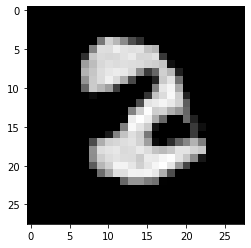

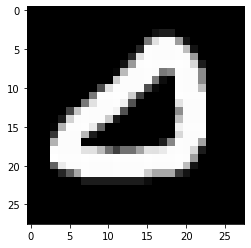

In [1150]:
# img=img*255
# img=img.astype('uint8')
ind = np.random.randint(batch_size)
plt.figure()
plt.imshow(img[ind], cmap='gray')
plt.figure()
plt.imshow(img2[ind], cmap='gray')

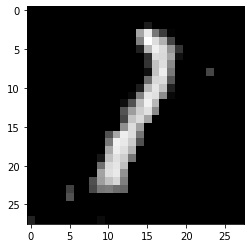

In [1226]:
x = torch.randn(1, latent_dim, 1,1).to(device)
img = netG(x).detach().cpu().numpy()

plt.imshow(img[0][0], cmap='gray')

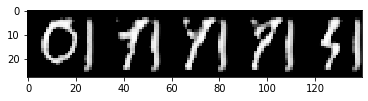

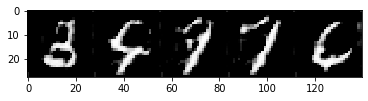

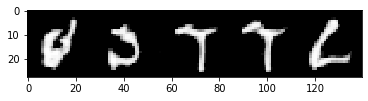

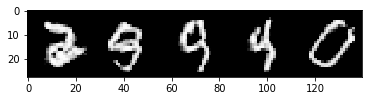

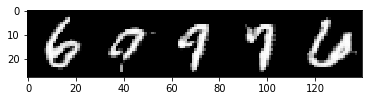

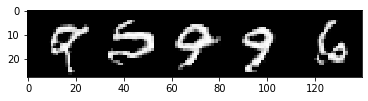

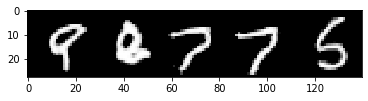

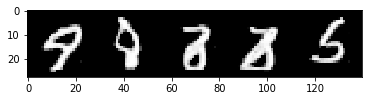

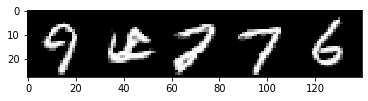

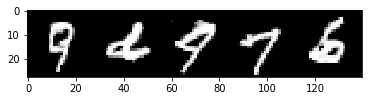

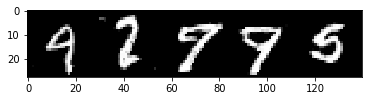

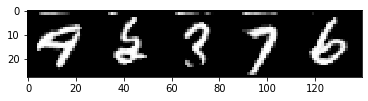

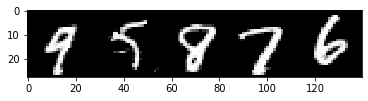

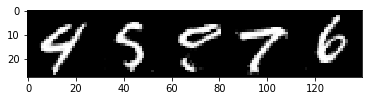

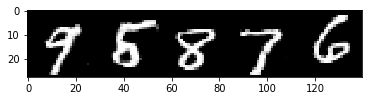

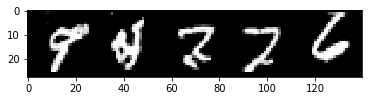

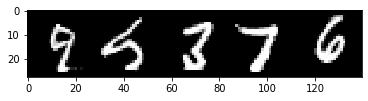

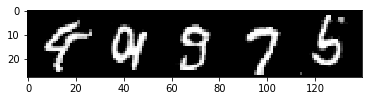

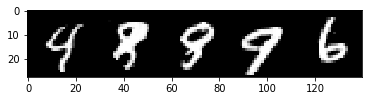

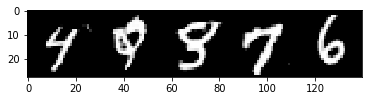

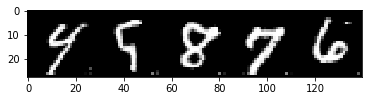

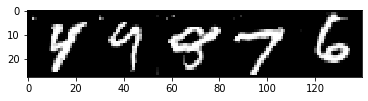

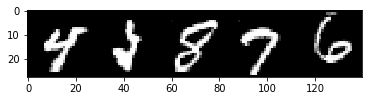

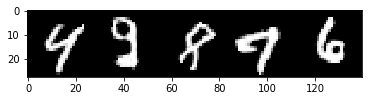

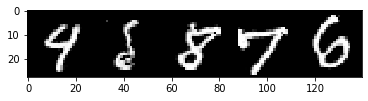

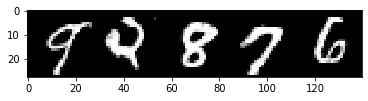

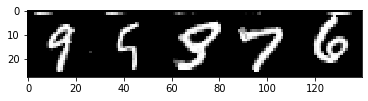

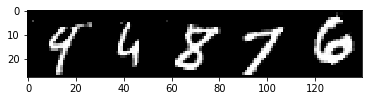

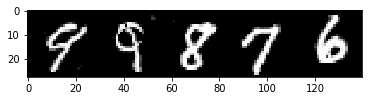

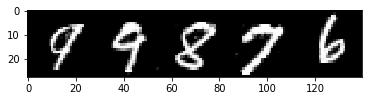

In [878]:
warnings.filterwarnings('ignore')
imgs = glob('./mnist_gan/*.png')
for i in imgs:
    plt.figure()
    plt.imshow(plt.imread(i), cmap='gray')

In [930]:
sp=.2
k = np.arange(-1,1+sp,sp)
x = np.array([[i,j] for i in k for j in k]).reshape(k.shape[0]**2, latent_dim, 1,1)

In [931]:
x_tensor = torch.tensor(x, dtype=torch.float32).to(device)

In [932]:
imgs = netG(x_tensor).detach().cpu().numpy().reshape(k.shape[0]**2, 28, 28)

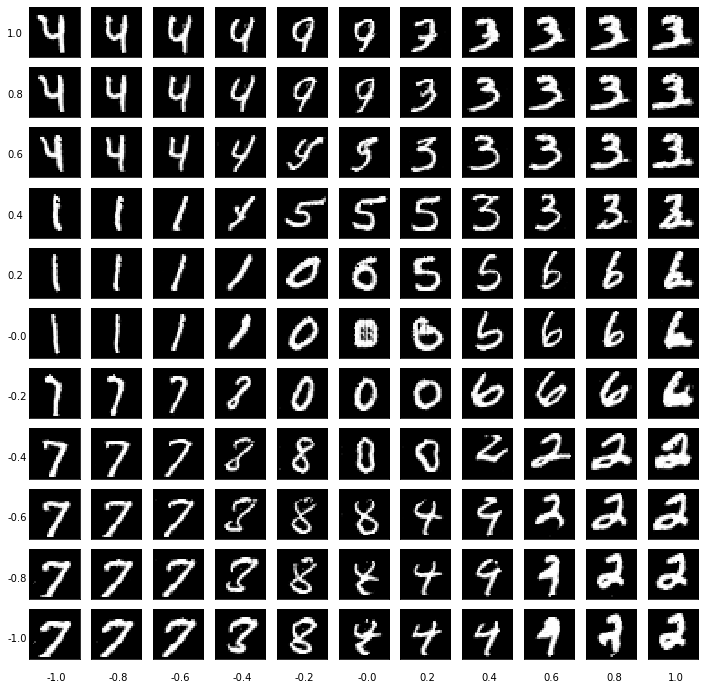

In [966]:
fig, ax = plt.subplots(k.shape[0], k.shape[0], figsize=[12,12]) 
for i in range(k.shape[0]):
    for j in range(k.shape[0]):
        ax[i,j].imshow(imgs[i*k.shape[0]+j], cmap='gray')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        

for i in range(k.shape[0]):
    fig.text(.145+.072*i, .1, '{:.1f}'.format(k[i]))
    fig.text(.1, .145+.07*i, '{:.1f}'.format(k[i]))

# fig.text(.15,.1,'-1')
# fig.text(.15+t,.1,'-0.5')
# fig.text(.15+t*2,.1,'-0.5')
# fig.text(.15+t*10,.1,'-0.5')

In [967]:
fig.savefig('mnist_gan/2-dim_digits_grids.png')